<a href="https://colab.research.google.com/github/brahma2024/LLM-study/blob/main/4_Becoming%2BBackprop%2BNinja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **4 - Becomming a backprop Ninja**

In [154]:
# No change in code from 3 - Activations&Gradients Lecture

In [155]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [156]:
!wget https://raw.githubusercontent.com/brahma2024/LLM-study/main/names.txt

--2024-06-19 20:57:08--  https://raw.githubusercontent.com/brahma2024/LLM-study/main/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228146 (223K) [text/plain]
Saving to: ‘names.txt.3’

names.txt.3         100%[===================>] 222.80K  --.-KB/s    in 0.05s   

2024-06-19 20:57:08 (4.42 MB/s) - ‘names.txt.3’ saved [228146/228146]



In [157]:
# read all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [158]:
# build the vocabulary of chracters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [159]:
# build dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)

      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

# split dataset into train | dev | test

import random
random.seed(0)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])       # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xtest, Ytest = build_dataset(words[n2:])   # 10%

torch.Size([182594, 3]) torch.Size([182594])
torch.Size([22846, 3]) torch.Size([22846])
torch.Size([22706, 3]) torch.Size([22706])


In [160]:
# boilerplate done above, action next

In [161]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()    # comparing all values of dt with t.grad and return a boolean value | if all values are equal returns TRUE
  app = torch.allclose(dt, t.grad)       # torch.allclose looks for values which are very very close, say to some nums of decimal, if Yes returns True | allows a little wiggle room
  maxdiff = (dt - t.grad).abs().max().item()  # what is the maxim difference if there is any
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [162]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducability
C = torch.randn((vocab_size, n_embd), generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # just to check for gradient wrt to b1, otherwise in actual NN training its useless because of batchNorm
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initialiazing many of these parameters in non-standard ways
# because sometimes initializing with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [163]:
# just training one batch
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix =torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # ix = list of random int between [0, Xtr.shape[0]]
Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

In [164]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embd the characters into vectors
embcat = emb.view(emb.shape[0], -1) # contcatenate the vectors
# Linear Layer 1
hprebn = embcat @ W1 + b1 # hidden layer preactivation
# BatchNorm Layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear Layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss ( same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values # from the log probs for each character, given a sample/example, fetch the largest log probability + its index
norm_logits = logits - logit_maxes # the index with largest prob = 0 rest -ve
counts = norm_logits.exp() # for value = 0, count= 1 and for rest 0 < counts < 1
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0/count_sum) instead then I can't backprop to be exact ..
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean() # reduce the loglikelihood to as small as zero

# pytorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts_sum_inv, counts_sum, counts,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, bnmeani, hprebn,
          embcat, emb]:
  t.retain_grad()
loss.backward()
loss


tensor(3.2823, grad_fn=<NegBackward0>)

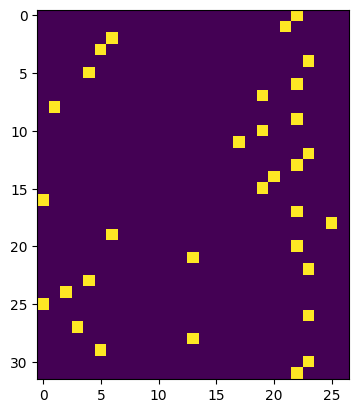

In [165]:
ixl = logits.max(1, keepdim=False).indices
dlogits1 = torch.zeros_like(logits)
dlogits1[torch.arange(n),ixl] = 1.0

# all of the options below graph the same output
# plt.imshow(F.one_hot(ixl, num_classes=logits.shape[1]))
plt.imshow(dlogits1) # shows which indexes have max
# plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1])) # where all values are 1

In [166]:
# @title Test Code: To verify the mathematical steps behind calculating the cross-entropy loss
# !pip install torchviz
# from torchviz import make_dot

# # Seed for reproducibility
# torch.manual_seed(0)

# # Example tensor calculations
# a = torch.randint(-100, 100, (10,5), dtype=torch.float, requires_grad=True)  # logits
# out = torch.randint(0,5,(5,))  # Yb
# a_max = a.max(1, keepdim=True).values  # logits_max
# b = a - a_max  # norm_logits
# b_count = b.exp()  # exponential of normalized logits
# b_count_sum = b_count.sum(1, keepdim=True)  # sum of exponentials
# b_count_sum_inv = b_count_sum.pow(-1)  # inverse of sum
# b_probs = b_count * b_count_sum_inv  # probabilities
# log_probs = b_probs.log()  # log probabilities
# loss = -(log_probs[torch.arange(5), out]).mean()  # cross-entropy loss

# # Generate graph
# # graph = make_dot(loss, params={'a': a})
# # graph.attr(rankdir='LR', size='24, 24')  # Set the graph to be left-to-right
# # graph.render("output_horizontal", format="png", cleanup=True)
# # graph

# from graphviz import Digraph

# # Create a new directed graph
# dot = Digraph(format='png')
# dot.attr(rankdir='LR')  # Left to Right graph

# # Adding nodes representing each step in your tensor operations
# dot.node('A', 'a = rand([-100, 100], [10,5])')
# dot.node('B', 'out = rand([0,5], [5,])')
# dot.node('C', 'a_max = max(a)')
# dot.node('D', 'b = a - a_max')
# dot.node('E', 'b_count = exp(b)')
# dot.node('F', 'b_count_sum = sum(b_count)')
# dot.node('G', 'b_count_sum_inv = 1 / b_count_sum')
# dot.node('H', 'b_probs = b_count * b_count_sum_inv')
# dot.node('I', 'log_probs = log(b_probs)')
# dot.node('J', 'loss = -mean(log_probs)')

# # Adding edges
# dot.edge('A', 'C', 'Calculate max per row')
# dot.edge('A', 'D', 'Subtract max')
# dot.edge('D', 'E', 'Exponential')
# dot.edge('E', 'F', 'Sum of exponentials')
# dot.edge('F', 'G', 'Inverse')
# dot.edge('E', 'H', 'Element-wise multiplication')
# dot.edge('G', 'H')
# dot.edge('H', 'I', 'Logarithm')
# dot.edge('I', 'J', 'Negative mean')

# # Render the graph to a file
# dot.render('tensor_operations', view=True)

# # Display the graph (if using Jupyter, for instance)
# dot


In [167]:
# @title Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

# --------------
# Calculate the Jacobian Matrix at each step
# --------------
# derivative of loss w.r.t. all elements of logprobs
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n      # for all indexes = Yb will be - 1/n derivative of mean
cmp('logprobs', dlogprobs, logprobs)

dprobs = (1.0 / probs) * dlogprobs # derivative of loss w.r.t. all elements of probs
cmp('probs', dprobs, probs)
# how does this works:
# if probs = 1.0 that is most characters are getting correctly generated in output so 1/probs = 1
# that means dlogprobs i.e. the gradients of loss wrt to logprobs gets a passthrough
# but if probs are incorrectly assigned, i.e. probs is very low,
# then 1/probs will be very large and will boost the dlogprobs to make the model learn fast

# probs = counts * counts_sum_inv  | i.e. we need to find the derivative both with respect to counts & counts_sum_inv
# 1: dcounts_sum_inv i.e. change in loss with respect to count_sum_inv
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
# here the node counts_sum_inv is used multiple times, and in the backward pass all the gradients from 27 (vocab_size) characters arrive at
# one node for each 32 example, so correct thing to do is to sum all the gradients at that node and maintain the shape
# counts_sum_inv is of shape [n, 1] so its gradient should be the same shape hence post summing, keepdim = True

# 2: dcounts i.e. dloss/dcounts | this is part 1 of dloss/dcount
dcounts = counts_sum_inv * dprobs

# now calculating dloss/dcounts_sum
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

# dloss/ dcounts | this is total dloss/dcount
# count node: impacts changes in probs and in counts_sum | so both these changes need to be added as part of the back propagation
dcounts += torch.ones_like(counts) * dcounts_sum # change in loss w.r.t. counts [chain rule applied]
cmp('counts', dcounts, counts)

# dnorm_logits = dcounts * norm_logits.exp() # dloss / dnorm_logits | counts = dnorm_logits.exp()
dnorm_logits = counts * dcounts
cmp('norm_logits', dnorm_logits, norm_logits)

# to allow for gradient pass through norm_logits = logits - logit_maxes | its in 2 parts
# 1: logit_maxes
# dlogit_maxes = (dnorm_logits * -torch.ones_like(logit_maxes)).sum(1, keepdim=True) # dloss/ dlogit_maxes | this is expensive since we are creating a new tensor with all ones
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True) # same as above, just a more neater implementation
cmp('logit_maxes', dlogit_maxes, logit_maxes)
# Just a side note: gradients of logits_max does not matter much when computing final loss
# reason: purpose of logit_max is only from the purpose of numerical stability and hence does not contribute much to the final loss
# print(f'{dlogit_maxes=}') # printing to see values of dlogits_maxes ~ 0.0

# 2: dlogits | this is the 1 part of the dlogits
# dlogits = dnorm_logits * torch.ones_like(logits) # expensive option since we are creating a new tensor with all ones
dlogits = dnorm_logits.clone()

# 2nd part of dlogits
# for logits.max(1, keepdim=True).values | what its doing is picking up the values with maximum value for each of n example sets
# method 1: the usual approach as used above
# dlogits1 = torch.zeros_like(logits) # all values initialized to zero
# dlogits1[range(n),logits.max(1, keepdim=False).indices] = 1.0 # only values at indices which had maximum value in fwd pass are assigned 1.0
# dlogits += dlogit_maxes * dlogits1 # gradient flowing from logit_maxes to logits is added to gradient flowing from node norm_logits
# method 2: using F.one_hot
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes # at indices selected one_hot will make value = 1, rest = 0
cmp('logits', dlogits, logits)

# gardient flow through activation layer logits = h @ W1 + b1
# dloss/dh
dh = dlogits @ W2.T # W2.t() = W2.T
cmp('h', dh, h)

# dloss/dW2
dW2 = h.T @ dlogits # h.t() = h.T
# print(dW2, dW2.t().shape, W2.shape)
cmp('W2', dW2, W2)

# dloss/db2
# db2 = (dlogits * torch.ones_like(b2)).sum(0, keepdim=True)
# db2 = (dlogits).sum(0, keepdim=True) # same but simpler implementation
db2 = (dlogits).sum(0, keepdim=False) # b2 is a 1D vector, hence heepdim=False
cmp('b2', db2, b2)


# dloss/dhpreact = 4/(e^(-x) + e^x)^2 | dtanh(x)^2 = sech(x)^ = 1 - tanh(x)^2
# dhpreact = dh * torch.sub(torch.ones_like(hpreact), (torch.tanh(hpreact)**2))
dhpreact = (1.0 - h**2) * dh # same as above, but simpler/easier to read
cmp('hpreact', dhpreact, hpreact)

# dloss/dbngain
dbngain = (dhpreact * bnraw).sum(0, keepdim=True) # bngain was broadcasted to all 32 rows(examples), so the gradient is summed up in that direction
cmp('bngain', dbngain, bngain)

# dloss/dbnraw
dbnraw = bngain * dhpreact
cmp('bnraw', dbnraw, bnraw)

# dloss/dbnbias
# dbnbias = (dhpreact * torch.ones_like(bnbias)).sum(0, keepdim=True)
dbnbias = (dhpreact).sum(0, keepdim=True) # bnbias was broadcasted to all 32 rows(examples), so the gradient is summed up in that direction
cmp('bnbias', dbnbias, bnbias)

# dloss/dbnvar_inv
# Ref.: bnraw = bndiff * bnvar_inv
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

# dloss/dbndiff: Part 1
dbndiff = bnvar_inv * dbnraw # bndiff part 1: this is 1st part of the gradient flowing through bndiff, part 2 when calc gradient flowing through bndiff2
# cmp('bndiff: Part 1', dbndiff, bndiff)

# dloss/dbnvar
# Ref.:bnvar_inv = (bnvar + 1e-5)**-0.5
dbnvar = dbnvar_inv * -(0.5 * (bnvar + 1e-5)**-1.5)
cmp('bnvar', dbnvar, bnvar)

# dloss/dbndiff2
# Ref.:bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
# dbndiff2 = 1.0/(n-1) * dbnvar
dbndiff2 = ((1.0/(n-1)) * torch.ones_like(bndiff2)) * dbnvar
cmp('bndiff2', dbndiff2, bndiff2)

# dloss/dbndiff: Part 2
# Ref.:bndiff2 = bndiff**2
dbndiff += 2 * bndiff * dbndiff2
cmp('bndiff: Full', dbndiff, bndiff)

# dloss/dhprebn: Part 1
# Ref.: bndiff = hprebn - bnmeani
dhprebn = dbndiff.clone()
# cmp('hprebn: Part 1', dhprebn, hprebn)

# dloss /dbnmeani
# Ref: bndiff = hprebn - bnmeani
# dbnmeani = -(torch.ones_like(bndiff) * dbndiff).sum(0, keepdim=True)
dbnmeani = (-dbndiff).sum(0, keepdim=True)
cmp('bnmeani', dbnmeani, bnmeani)

# dloss/dhprebn: Part 2
# Ref.:bnmeani = 1/n*hprebn.sum(0, keepdim=True)
dhprebn += 1/n * (torch.ones_like(hprebn) * dbnmeani)
# dhprebn += 1/n * (dbnmeani).sum(0, keepdim=True)  # this is another approach
cmp('hprebn: Full', dhprebn, hprebn)

# dloss/dembcat
# Ref: hprebn = embcat @ W1 + b1
dembcat = dhprebn @ W1.T
cmp('embcat', dembcat, embcat)

# dloss/dW1
dW1 = embcat.T @ dhprebn
cmp('W1', dW1, W1)

# dloss/db1
db1 = dhprebn.sum(0, keepdim=False) # keepdim=False, since b1 is a 1D tensor
cmp('b1', db1, b1)

# dloss/demb
# Ref:embcat = emb.view(emb.shape[0], -1)
# demb = dembcat.view(emb.shape[0], emb.shape[1], emb.shape[2]) # more not-so-sensible version
demb = dembcat.view(emb.shape)
cmp('emb', demb, emb)

# dloss/demb
# Ref: emb = C[Xb]
# Explanation: Here what C[Xb] is actually doing is, for all examples in input batch Xb
# it looks up into the embedding table C, and pulls out the embedding vector corresponding to that itos map (a = 1, .=0, and so on)
# Now when passing the gradients through C[Xb], it might be the possibility that one index position in embedding table C is called multiple time
# e.g. print(Xb[:5])
# returns tensor([[ 0,  0,  0],
#        [ 1, 14,  7],
        # [ 0,  0, 11],
        # [18,  9,  5],
        # [18,  9,  1]]) ---> like 0, 1, 9, 18 are referenced multiple times
# so the gradient for these needs to added together
# this can be done using for loop
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    xkj = Xb[k,j]
    dC[xkj] += demb[k,j]

cmp('C', dC, C)


logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bngain          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bnraw           | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bnbias  

In [168]:
for i in range(emb.shape[0]):
  for j in range(emb.shape[1]):
    # print(i,j, '---', C[Xb][i,j] == emb[i, j])
    ixt = Xb[i,j]
    print(ixt, '---> ', C[ixt], '--->', C[Xb][i,j])

tensor(0) --->  tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046], grad_fn=<SelectBackward0>) ---> tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046], grad_fn=<SelectBackward0>)
tensor(0) --->  tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046], grad_fn=<SelectBackward0>) ---> tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046], grad_fn=<SelectBackward0>)
tensor(0) --->  tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046], grad_fn=<SelectBackward0>) ---> tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046], grad_fn=<SelectBackward0>)
tensor(1) --->  tensor([-0.4713,  0.7868, -0.3284, -0.4330,  1.3729,  2.9334,  1.5618, -1.6261,
         0.6772, -0.8404], grad_fn=<S

In [169]:
dC = torch.zeros_like(C)
dC[Xb].shape

torch.Size([32, 3, 10])

In [170]:
emb.shape, C.shape, C[Xb][1,0], C.grad.shape

(torch.Size([32, 3, 10]),
 torch.Size([27, 10]),
 tensor([-0.4713,  0.7868, -0.3284, -0.4330,  1.3729,  2.9334,  1.5618, -1.6261,
          0.6772, -0.8404], grad_fn=<SelectBackward0>),
 torch.Size([27, 10]))

# Matrix Multiply | Element-wise multiplication between matrices
**Matrix Multiply**
between matrices A & B = dot product between A-rows and B-columns

**Element-wise mulitplication**
Each element
𝑎
𝑖
𝑗
a
ij
​
  from the broadcasted tensor a is multiplied with the corresponding element
𝑏
𝑖
𝑗
b
ij
​
  from tensor b.
Result is a new tensor c of shape (32, 64) where each element
𝑐
𝑖
𝑗
=
𝑎
𝑖
𝑗
×
𝑏
𝑖
𝑗
c
ij
​
 =a
ij
​
 ×b
ij
​


In [171]:
# @title Example 2: backprop thorugh cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass
# norm_logits = logits - logit_maxes
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdim=True)
# counts_sum_inv = counts_sum**-1
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())


3.282268524169922 diff: 2.384185791015625e-07


In [172]:
# backward_pass

# Here we reduce all the work we did in the steps below, as part of Exercise 1, into a single line
# dlogprobs = torch.zeros_like(logprobs)
# dlogprobs[range(n), Yb] = -1.0/n
# dprobs = (1.0 / probs) * dlogprobs
# dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
# dcounts = counts_sum_inv * dprobs
# dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
# dnorm_logits = counts * dcounts
# dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
# dlogits = dnorm_logits.clone()
# dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

# First: Reduce this loss function into a simple single line loss function
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdim=True)
# counts_sum_inv = counts_sum**-1
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()
loss_softmax = - (torch.exp(logits)/(torch.exp(logits).sum(1, keepdim=True)))[range(n), Yb].log().mean()

print(loss_softmax.item(), 'diff:', (loss_softmax - loss).item())
# Next: Differentiate through it
dlogits = (torch.exp(logits)/(torch.exp(logits).sum(1, keepdim=True)))
dlogits[range(n), Yb] -= 1.0
dlogits /= n

# Understanding the gradient calculation for loss  wrt to logits i.e. dloss/dlogits
# Seperating out the 2 conditions: if the index inside logits = Yb (output label) | index inside logits != Yb (output label)
# in Condition 1: gradient of the loss wrt to the index inside logits = Yb, is = (softmax - 1.0)/n
# in Condition 2: gradient of the loss wrt to the index inside logits != Yb (output label), is = softmax/n
# where division by n counters the sum across n batches in the forward pass

# Another implementation
# dlogits = F.softmax(logits, 1)
# dlogits[range(n), Yb] -= 1.0
# dlogits /= n
cmp('logits', dlogits, logits)

3.2822682857513428 diff: 0.0
logits          | exact: False | approximate: True  | maxdiff: 7.916241884231567e-09


In [173]:
# calculating the probabilities of the logits
# and just taking the 1st row
F.softmax(logits, 1)[0]

tensor([0.0178, 0.0145, 0.0508, 0.0161, 0.0339, 0.0174, 0.0816, 0.0371, 0.0508,
        0.0499, 0.0216, 0.0309, 0.0339, 0.0335, 0.0205, 0.0525, 0.0615, 0.0487,
        0.0381, 0.0218, 0.0399, 0.0339, 0.0954, 0.0104, 0.0229, 0.0347, 0.0299],
       grad_fn=<SelectBackward0>)

In [174]:
# if we take the gradient of the 1st row * multiple by n to undo the scaling
# we get the actual probabilities
dlogits[0] * n

tensor([ 0.0178,  0.0145,  0.0508,  0.0161,  0.0339, -0.9826,  0.0816,  0.0371,
         0.0508,  0.0499,  0.0216,  0.0309,  0.0339,  0.0335,  0.0205,  0.0525,
         0.0615,  0.0487,  0.0381,  0.0218,  0.0399,  0.0339,  0.0954,  0.0104,
         0.0229,  0.0347,  0.0299], grad_fn=<MulBackward0>)

In [175]:
# and it can be noticed that the only for the index = Yb has a ~ -1.0
# what does that mean that the gradient is putting a collective effort to reduce the
# and sum of dlogits should =~ 1.0
dlogits.sum()

tensor(-3.7253e-09, grad_fn=<SumBackward0>)

In [176]:
# this can be thought of as the gradient at each cell as a force
# since during training gradient is applied as - leraning_rate * gradient
# its trying to make the logit of the correct index/cell as close to 0 as possible so that e^0 = 1 i.e. gets a higher probability
# and is trying to pull the values of the other cells/indexes down, for a given example
# with the collective force summing up to 0.0

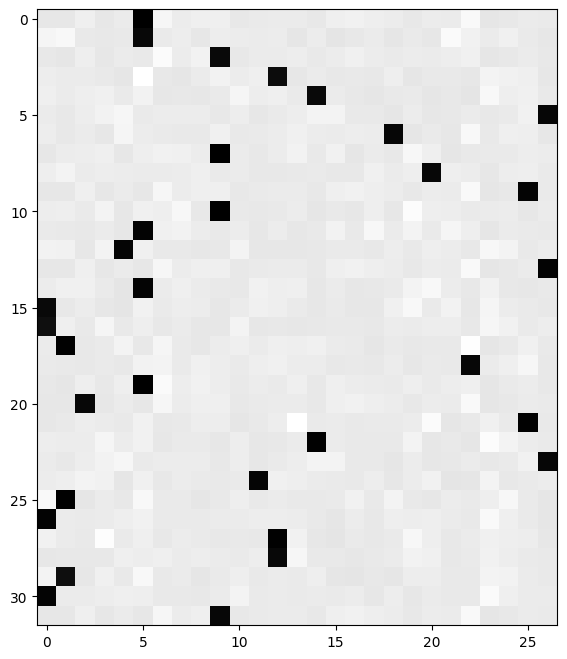

In [177]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap='gray')

# black squares are the indices where we performed -= 1.0

In [178]:
# @title Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take a derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# Before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# Now:
# # Mthod 1:
# bndiff_fast = (hprebn - hprebn.mean(0, keepdim=True))
# print('bndiff_fast', 'diff:', torch.all(bndiff_fast == bndiff))

# bnvar_fast = ((1/(n-1))*(((hprebn - hprebn.mean(0, keepdim=True))**2).sum(0, keepdim=True)))
# print('bnvar_fast', 'diff:', torch.all(bnvar_fast == bnvar))

# bnraw_fast_1 = bndiff_fast * (bnvar_fast + 1e-5)**-0.5
# print('bnraw_fast_1', 'diff:', torch.all(bnraw_fast_1 == bnraw))

# bnraw_fast = (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(((1/(n-1))*(((hprebn - hprebn.mean(0, keepdim=True))**2).sum(0, keepdim=True))) + 1e-5)

# Method 2:
bnraw_fast = (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, correction=1))
print('bnraw_fast', 'diff:', torch.all(bnraw_fast == bnraw))

hpreact_fast = bngain * bnraw_fast + bnbias
print('hpreact_fast', 'diff:', torch.all(hpreact_fast == hpreact))

print('max diff:', (hpreact_fast - hpreact).abs().max())

bnraw_fast diff: tensor(False)
hpreact_fast diff: tensor(False)
max diff: tensor(2.5749e-05, grad_fn=<MaxBackward1>)


In [179]:
hprebn.var(0, keepdim=True), bnvar

(tensor([[3.1335, 2.0495, 2.3350, 1.2706, 5.2063, 1.9729, 2.5762, 2.9609, 0.8553,
          0.9468, 1.2785, 1.8114, 3.3689, 1.6224, 0.7143, 2.3032, 3.3543, 6.5057,
          1.3057, 4.4658, 3.5887, 1.7295, 3.0513, 2.4652, 1.2883, 2.9347, 2.0102,
          1.7779, 3.4728, 2.0461, 1.9141, 2.4270, 2.6702, 2.4235, 3.0248, 2.4040,
          2.9726, 3.6039, 0.3378, 1.2289, 0.8259, 3.4072, 2.2100, 1.4483, 2.1420,
          1.8644, 2.2749, 1.6203, 1.0987, 2.6631, 2.1233, 0.9670, 2.5863, 4.7339,
          1.7726, 3.4225, 1.3726, 1.6840, 2.6751, 0.8119, 2.7571, 1.9284, 2.6743,
          2.2856]], grad_fn=<VarBackward0>),
 tensor([[3.1335, 2.0495, 2.3350, 1.2706, 5.2063, 1.9729, 2.5762, 2.9609, 0.8553,
          0.9468, 1.2785, 1.8114, 3.3689, 1.6224, 0.7143, 2.3032, 3.3543, 6.5057,
          1.3057, 4.4658, 3.5887, 1.7295, 3.0513, 2.4652, 1.2883, 2.9347, 2.0102,
          1.7779, 3.4728, 2.0461, 1.9141, 2.4270, 2.6702, 2.4235, 3.0248, 2.4040,
          2.9726, 3.6039, 0.3378, 1.2289, 0.8259, 3.4

In [182]:
# backward pass over batchnorm

# Before:
# dhpreact = (1.0 - h**2) * dh
# dbngain = (dhpreact * bnraw).sum(0, keepdim=True)
# dbnraw = bngain * dhpreact
# dbnbias = (dhpreact).sum(0, keepdim=True) # bnbias was broadcasted to all 32 rows(examples), so the gradient is summed up in that direction
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbndiff = bnvar_inv * dbnraw
# dbnvar = dbnvar_inv * -(0.5 * (bnvar + 1e-5)**-1.5)
# dbndiff2 = ((1.0/(n-1)) * torch.ones_like(bndiff2)) * dbnvar
# dbndiff += 2 * bndiff * dbndiff2
# dhprebn = bndiff.close()
# dbnmeani = (-dbndiff).sum(0, keepdim=True)
# dhprebn += 1/n * (torch.ones_like(hprebn) * dbnmeani)

# Next: Calculate dhprebn given dhpreact ( i.e. backprop through the batchnorm)
# ( you'll also need to use some of the variables from the forward pass above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn)



hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [ ]:
# MAthematical expression for the Batch Norm backward pass
https://www.notion.so/Mathematical-expression-for-Batch-Norm-backward-pass-2d6f8f908a6c4cda8d86af156f58db95

In [ ]:
# @title Example 4: Putting it all together
# Need to come back to this :-|